## Example 1: Multiple linear regression

Import libraries

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from matplotlib.lines import Line2D

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1234)

Load data

In [3]:
data = bmb.load_data("ESCS")

Initialize and fit model

In [4]:
model = bmb.Model("drugs ~ o + c + e + a + n", data)
idata = model.fit(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [drugs_sigma, Intercept, n, a, e, c, o]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.


Plot model priors

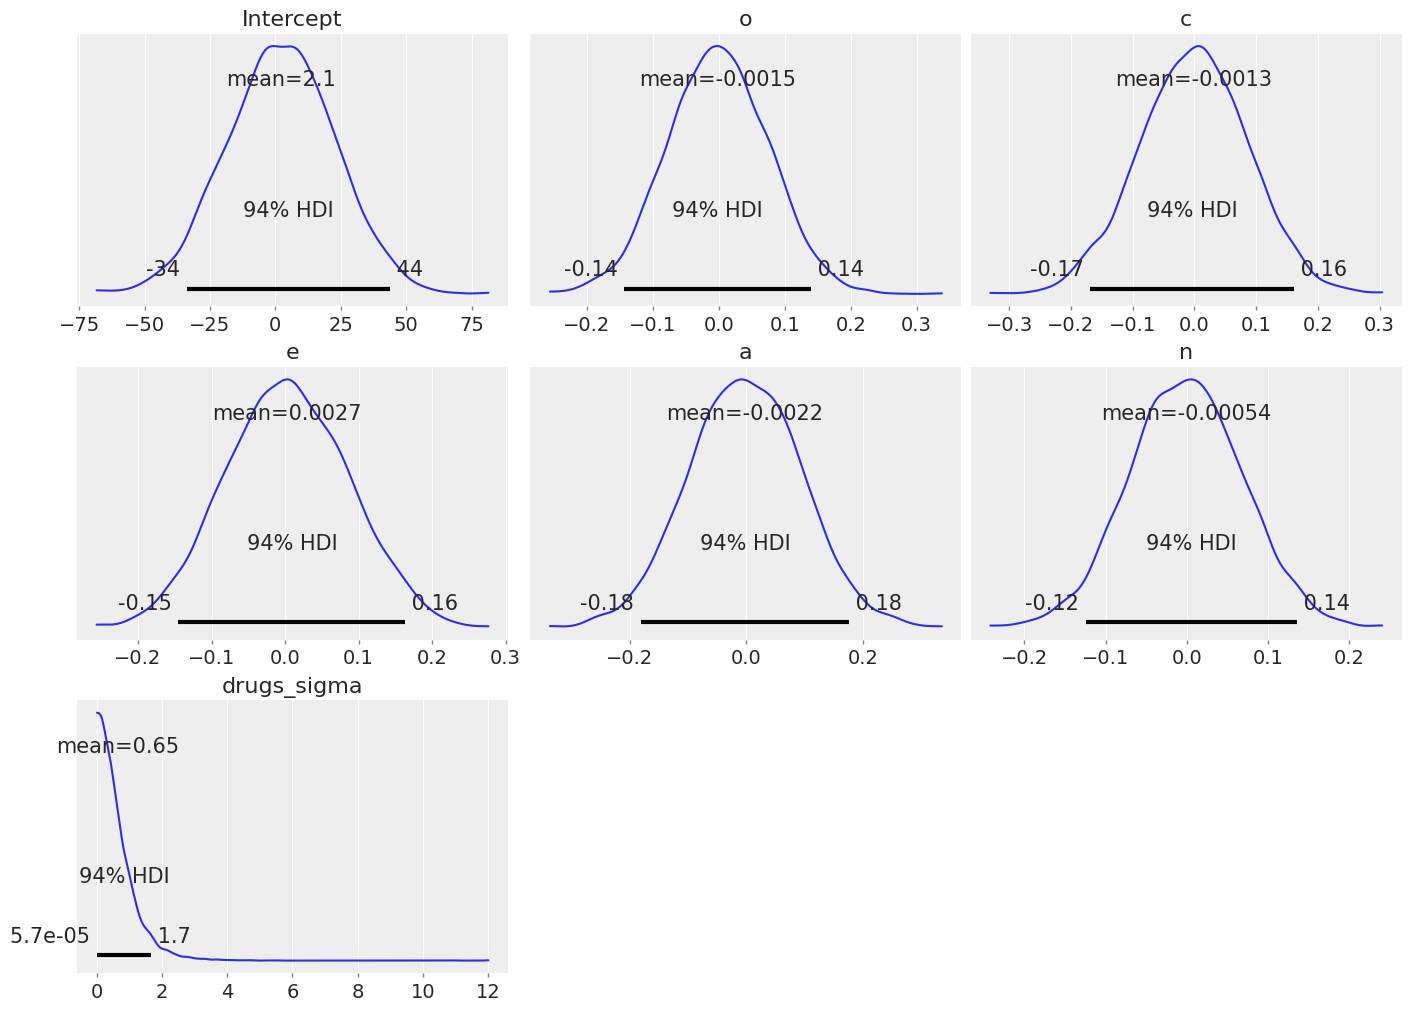

In [5]:
model.plot_priors(figsize = (14, 10));
plt.savefig("imgs/drugs_prior.png")

Inspection of InferenceData object

In [6]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Numerical summary of the posterior with diagnostics

In [7]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.311,0.367,2.660,4.007,0.006,0.004,3847.0,3149.0,1.0
o,0.006,0.001,0.004,0.009,0.000,0.000,4270.0,3007.0,1.0
c,-0.004,0.001,-0.007,-0.001,0.000,0.000,4257.0,3446.0,1.0
e,0.003,0.001,0.001,0.006,0.000,0.000,4266.0,3163.0,1.0
a,-0.012,0.002,-0.015,-0.010,0.000,0.000,4349.0,3187.0,1.0
n,-0.002,0.001,-0.004,0.001,0.000,0.000,4109.0,3248.0,1.0
drugs_sigma,0.593,0.017,0.559,0.623,0.000,0.000,4765.0,3261.0,1.0


Density estimates and traceplots of marginal posteriors

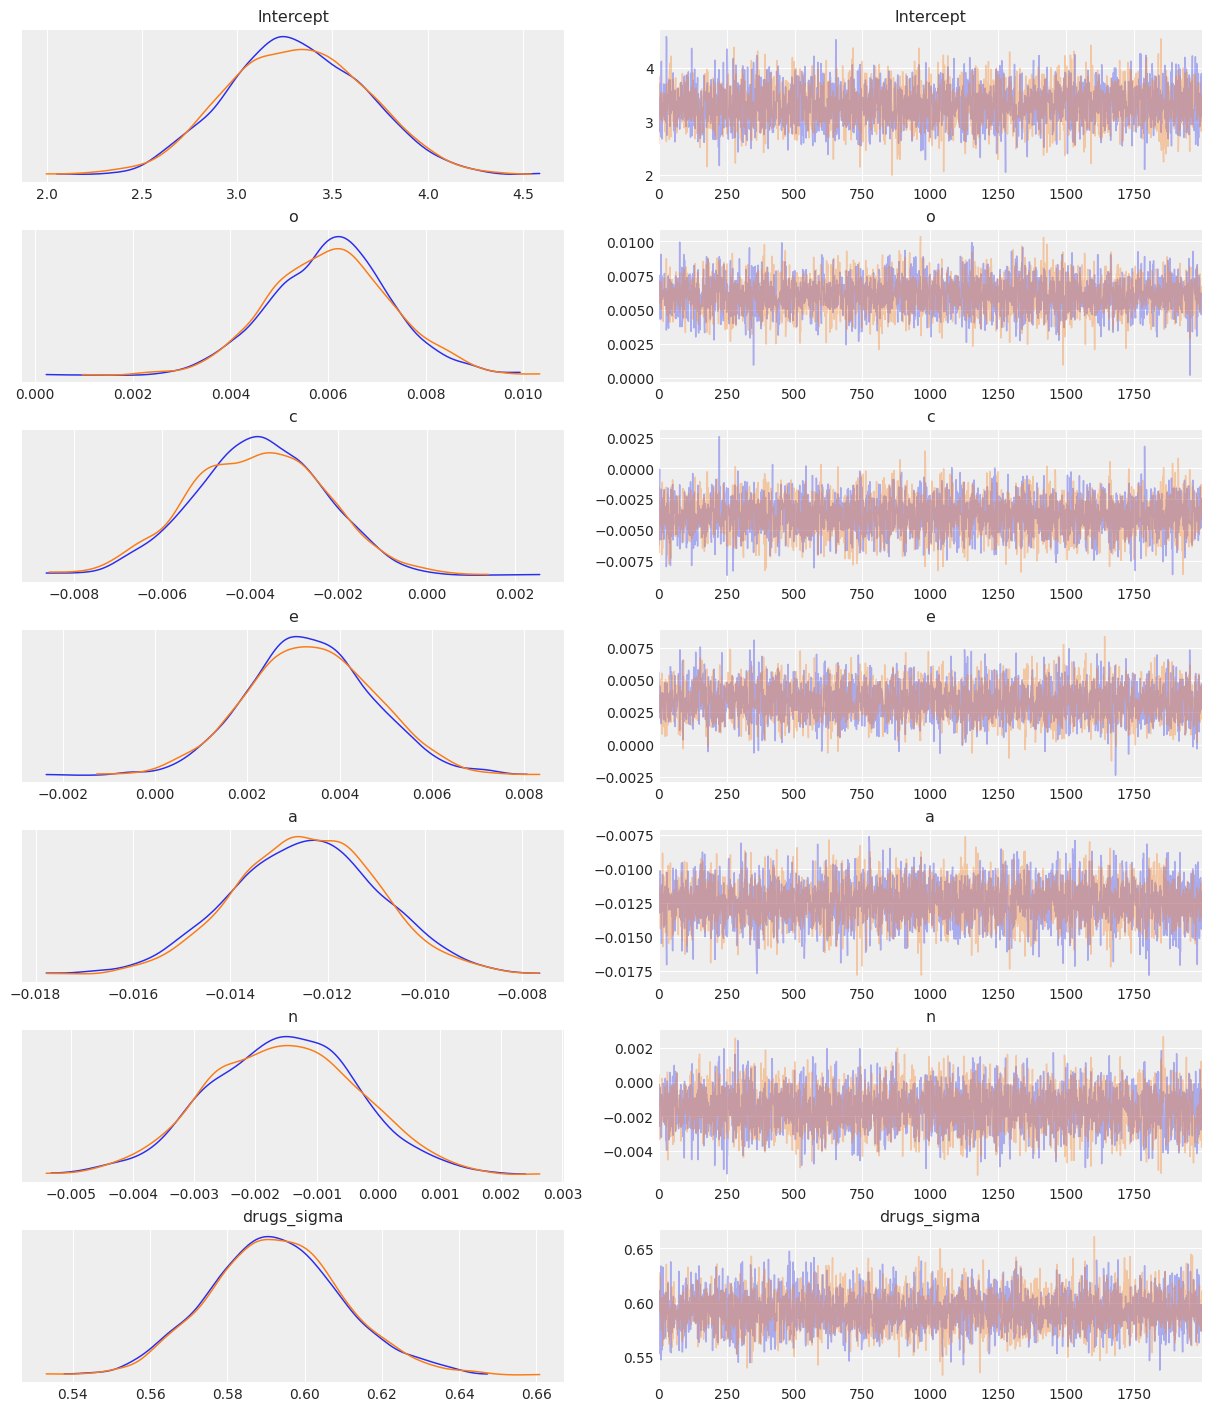

In [8]:
az.plot_trace(idata, compact=False);
plt.savefig("imgs/drugs_posterior.png")

Summarize effects on partial correlation scale. First we compute some statistics.

In [9]:
# X = common effects design matrix (excluding intercept/constant term)
terms = [t for t in model.common_terms.values() if t.name != "Intercept"]

x_matrix = [pd.DataFrame(x.data, columns=x.levels) for x in terms]
x_matrix = pd.concat(x_matrix, axis=1)

dm_statistics = {
    "r2_x": pd.Series(
        {
            x: sm.OLS(
                endog=x_matrix[x],
                exog=sm.add_constant(x_matrix.drop(x, axis=1))
                if "Intercept" in model.term_names
                else x_matrix.drop(x, axis=1),
            )
            .fit()
            .rsquared
            for x in list(x_matrix.columns)
        }
    ),
    "sigma_x": x_matrix.std(),
    "mean_x": x_matrix.mean(axis=0),
}

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [10]:
samples = idata.posterior

# the names of the predictors
varnames = ["o", "c", "e", "a", "n"]

# compute the needed statistics
r2_x = dm_statistics["r2_x"]
sd_x = dm_statistics["sigma_x"]
r2_y = pd.Series(
    [
        sm.OLS(
            endog=data["drugs"],
            exog=sm.add_constant(data[[p for p in varnames if p != x]]),
        )
        .fit()
        .rsquared
        for x in varnames
    ],
    index=varnames,
)
sd_y = data["drugs"].std()

# compute the products to multiply each slope with to produce the partial correlations
slope_constant = (sd_x[varnames] / sd_y) * ((1 - r2_x[varnames]) / (1 - r2_y)) ** 0.5
slope_constant
pcorr_samples = samples[varnames] * slope_constant

In [11]:
labels = [
    "Openness to experience",
    "Conscientiousness",
    "Extraversion",
    "Agreeableness",
    "Neuroticism",
]

<ipython-input-12-bc5d99dd8a34>:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(bottom=0.1, top=0.925, left=0.026, right=0.99, wspace=0.09)


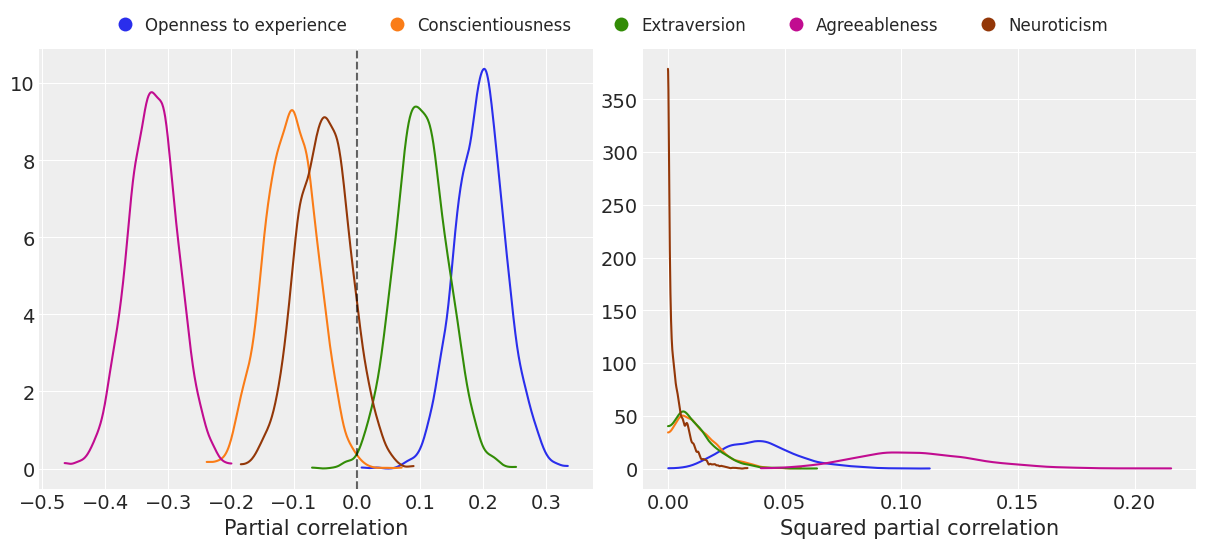

In [12]:
# Pass the same axes to az.plot_kde to have all the densities in the same plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5.33))

for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_kde(v, plot_kwargs={"color": f"C{idx}"}, ax=ax[0])
    az.plot_kde(v ** 2, plot_kwargs={"color": f"C{idx}"}, ax=ax[1])

ax[0].axvline(x=0, color="k", linestyle="--", alpha=0.6)
ax[0].set_xlabel("Partial correlation")
ax[1].set_xlabel("Squared partial correlation")

fig.subplots_adjust(bottom=0.1, top=0.925, left=0.026, right=0.99, wspace=0.09)

# Create legend
handles = [
    Line2D(
        [0], [0], label=label, marker="o", color="None", 
        markerfacecolor=f"C{i}", markeredgewidth=0, markersize=10
    )
    for i, label in enumerate(labels)
]

# Add legend
legend = fig.legend(
    handles=handles, 
    ncol=5,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.925),
    handletextpad=0.2,
    columnspacing=2,
    fontsize=12,
)

# Slightly adjust vertical position of the texts
for text in legend.get_texts():
    text.set_position((0, -0.21))

# Save plot
plt.savefig("imgs/drugs_pcorr.png")

The means of these distributions serve as good point estimates of the partial correlations:

In [13]:
pcorr_samples.mean(dim=["chain", "draw"]).squeeze(drop=True)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    o        float64 0.1961
    c        float64 -0.1058
    e        float64 0.1022
    a        float64 -0.3249
    n        float64 -0.05308

In [14]:
sq_partial_c = pcorr_samples["c"].stack(draws=("chain", "draw")).values ** 2
sq_partial_o = pcorr_samples["o"].stack(draws=("chain", "draw")).values ** 2

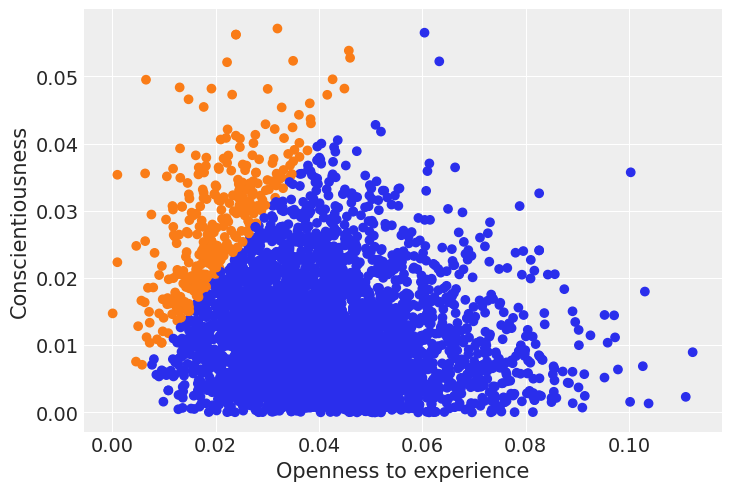

In [15]:
# Just grab first to colors from color map
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][:2]
colors = [colors[1] if x > y else colors[0] for x, y in zip(sq_partial_c, sq_partial_o)]

plt.scatter(sq_partial_o, sq_partial_c, c=colors)
# plt.title("Samples from the joint posterior of\n Conscientiousness and Openness to experience")
plt.xlabel("Openness to experience")
plt.ylabel("Conscientiousness")
plt.savefig("imgs/drugs_scatter.png")

Probability that `o`^2 is larger than `c`^2.

In [16]:
(pcorr_samples['o'] ** 2 > pcorr_samples['c'] ** 2).mean()

<xarray.DataArray ()>
array(0.92025)

Correlation is not 0

In [17]:
np.corrcoef(sq_partial_c, sq_partial_o)[0, 1]

-0.19192549382048135

For each predictor, what is the probability that it has the largest squared partial correlation?

In [18]:
pc_df = pcorr_samples.to_dataframe()
(pc_df**2).idxmax(axis=1).value_counts() / len(pc_df.index)

a    0.9875
o    0.0125
dtype: float64

In [19]:
model.predict(idata, kind="pps", draws=250) # 250 per chain -> 500 in total

In [20]:
# Is this right? 
mean = idata.posterior_predictive["drugs"].values.ravel()

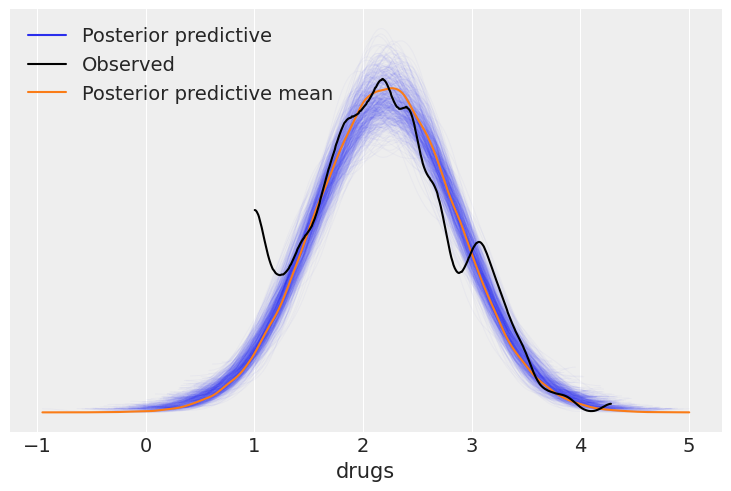

In [21]:
ax = az.plot_ppc(idata, color="C0", alpha=0.03, mean=False)
az.plot_dist(mean, color="C1", label = "Posterior predictive mean", ax=ax)
plt.savefig("imgs/drugs_ppc.png")

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Aug 20 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

matplotlib : 3.4.3
pandas     : 1.3.1
arviz      : 0.11.2
bambi      : 0.6.0
json       : 2.0.9
statsmodels: 0.12.2
numpy      : 1.21.2

Watermark: 2.1.0

